In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage as ndimage    
from skimage import measure
from shapely.geometry import Polygon

### Create Test surface

Using 2d perlin noise, we'll assume the grid spacing is 1m

In [2]:
def fade(t):
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def lerp(a, b, x):
    return a + x * (b - a)

def gradient(h, x, y):
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:,:,0] * x + g[:,:,1] * y

def perlin(x, y, seed=0):
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    xi = x.astype(int)
    yi = y.astype(int)
    xf = x - xi
    yf = y - yi
    u = fade(xf)
    v = fade(yf)
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    return lerp(x1, x2, v)

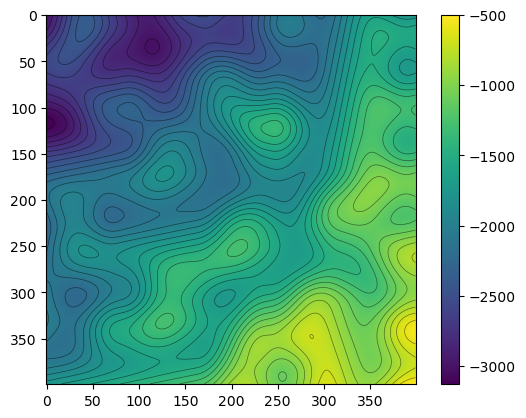

In [102]:
x = np.linspace(0, 5, 400)
y = np.linspace(0, 5, 400)
xv, yv = np.meshgrid(x, y)
z = perlin(xv, yv, seed=4) * 1000 - 3000 + xv * 250 + yv * 250

plt.imshow(z)
plt.colorbar()
plt.contour(z, levels=30, colors='black', linewidths=0.5, linestyles='solid', alpha=0.5)
plt.show()

### Find Closures


In [97]:
levels = np.arange(np.round(z.min()) - 1, np.round(z.max()) + 1)
closure_contours = []
closure_contours_dicts = []

threshold_area = 500  #m^2
threshold_closure = 10  #m

# Loop over depths - starting at the deepest
for level in levels:
    # Extract contours for given level
    contours = measure.find_contours(z, level)
    
    for contour in contours:
        # Check if contour is closed
        if (contour[0] == contour[-1]).all():
            
            # Calculate area, check above threshold
            closed_contour = Polygon(contour)
            area = closed_contour.area
            
            # Check is contour is inside deeper closed contour
            inside_flag = False
            for cc in closure_contours:
                if cc.contains(closed_contour):
                    inside_flag = True
                    break
                    
            if not inside_flag:
            
                # Check contour is larger than threshold area
                if area > threshold_area:

                    # Check contour defines a high region
                    # Create an empty image to store the masked array    
                    grid_mask = np.zeros_like(z, dtype='bool')
                    # Create a contour image by using the contour coordinates rounded to their nearest integer value
                    grid_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
                    # Fill in the hole created by the contour boundary
                    grid_mask = ndimage.binary_fill_holes(grid_mask)
                    # Find min and max values inside contour
                    c_zmin, c_zmax, c_zmean = np.nanmin(z[grid_mask]), np.nanmax(z[grid_mask]), np.nanmean(z[grid_mask])

                    if c_zmax > level + threshold_closure and c_zmean > level:
                        
                        # Create dictionary for each closed contour and store in a list                 
                        temp_dict = {'Level': level, 'Crest': c_zmax, 'Area': area, 'Polygon': closed_contour}
                        closure_contours_dicts.append(temp_dict)
                        
                        # Store a list of closed contours to check shallower levels are not inside
                        closure_contours.append(closed_contour)

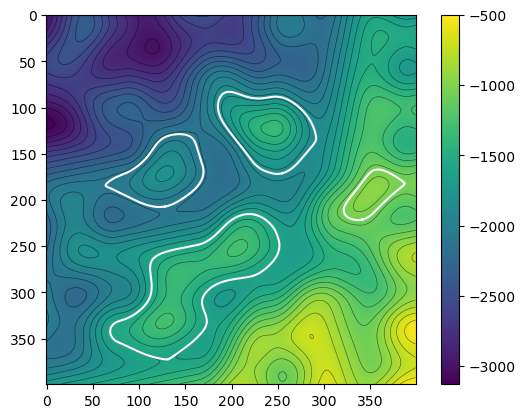

In [101]:
plt.imshow(z)
plt.colorbar()
plt.contour(z, levels=30, colors='black', linewidths=0.5, linestyles='solid', alpha=0.5)

for c in closure_contours_dicts:
    co = c['Polygon']
    plt.plot(*co.exterior.xy[::-1], 'w')

In [99]:
closure_contours_dicts = sorted(closure_contours_dicts, key=lambda x: x['Area'], reverse=True)

df = pd.DataFrame(closure_contours_dicts)
df

,Level,Crest,Area,Polygon
0,-1595.0,-1270.616152,12459.770042,"POLYGON ((372.0956998606989 132, 372.577237184..."
1,-1844.0,-1357.267057,6302.202608,"POLYGON ((171.07488471486144 255, 171.32659388..."
2,-2074.0,-1773.056682,4962.104827,"POLYGON ((207.10739987395226 128, 207.27821493..."
3,-1057.0,-956.960704,1949.100304,"POLYGON ((221.10683367238195 342, 221.34920209..."
